## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-4-clean-polish/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_1/'
fold_n = 1
# Unzip files
!tar -xf /kaggle/input/jigsaw-data-split-roberta-192-ratio-4-clean-polish/fold_1.tar.gz

Train samples: 668050


,comment_text,toxic,length,word_count,token_count,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,He should have been in Anchorage where selling Spice is a misdemeanor no matter how many people died from it or how ...,0.0000,679,118,161,0,train,train,train,validation,train
1,"Completely untrue, he's an equal opportunity RACIST whom even hates whitey. We all know Trump represents no single r...",0.6000,508,84,130,1,validation,train,train,train,train
2,Am I supposed to be scared? It's not like I can't just change my IP if I wanted to vandalize my own user page again....,1.0000,592,107,147,1,train,validation,train,train,train
3,You realize this isn't a partisan issue right? BOTH dems and republicans do this shit constantly. Instead of blaming...,0.7413,165,26,40,1,validation,train,train,train,train
4,Great article. Reads a bit like a Frederick Forsyth novel. Incredible how these spooks all work together. Niel Barna...,0.0000,885,148,215,0,validation,train,train,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,es,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",it,0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",es,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,tr,0


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 3,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'MAX_LEN': 192,
 'BATCH_SIZE': 128,
 'EPOCHS': 3,
 'LEARNING_RATE': 1e-05,
 'ES_PATIENCE': None,
 'base_model_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/tf-xlm-roberta-large-tf_model.h5',
 'config_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/xlm-roberta-large-config.json'}

## Learning rate schedule

Learning rate schedule: 0 to 9.96e-06 to 3.61e-07


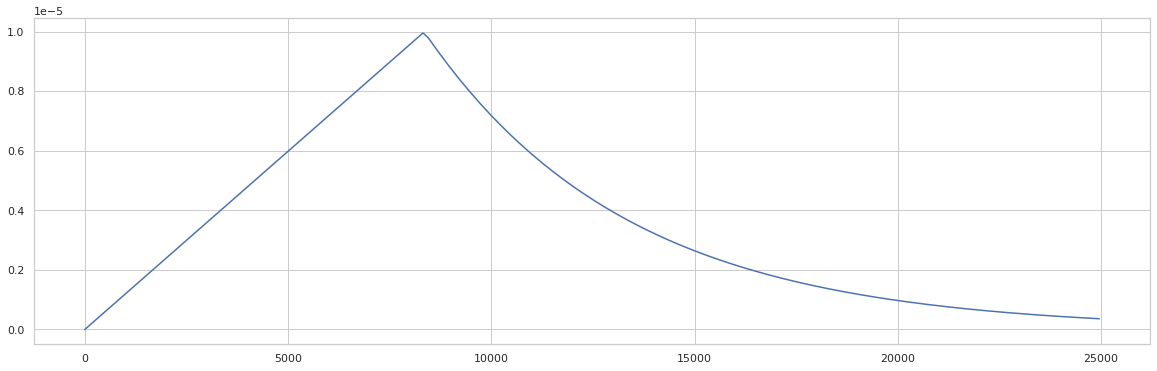

In [5]:
lr_min = 1e-7
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = (len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 1
decay = .9998

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps, hold_max_steps, 
                                      lr_start, lr_max, lr_min, decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train_int.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid_int.npy').reshape(x_valid.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train_tail = np.load(base_data_path + 'x_train_tail.npy')
y_train_tail = np.load(base_data_path + 'y_train_int_tail.npy').reshape(x_train_tail.shape[1], 1).astype(np.float32)
x_train = np.hstack([x_train, x_train_tail])
y_train = np.vstack([y_train, y_train_tail])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
valid_2_step_size = x_valid.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
valid_2_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)
valid_2_data_iter = iter(valid_2_dist_ds)

In [8]:
# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

@tf.function
def valid_2_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_2_auc.update_state(y, probabilities)
        valid_2_loss.update_state(loss)
    for _ in tf.range(valid_2_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

In [9]:
# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    
    lr = lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                  warmup_steps=warmup_steps, lr_start=lr_start, 
                                                  lr_max=lr_max, decay=decay)
    
    optimizer = optimizers.Adam(learning_rate=lr)
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    valid_2_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    valid_2_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc, 
                'val_2_loss': valid_2_loss, 'val_2_auc': valid_2_auc}

history = custom_fit_2(model, metrics_dict, train_step, valid_step, valid_2_step, train_data_iter, 
                       valid_data_iter, valid_2_data_iter, step_size, valid_step_size, valid_2_step_size, 
                       config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
# x_train = np.load(base_data_path + 'x_train.npy')
# x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

# train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
# valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'train', f'pred_{fold_n}'] = np.round(train_preds)
# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'validation', f'pred_{fold_n}'] = np.round(valid_preds)
valid_df[f'pred_{fold_n}'] = valid_ml_preds

Train for 8350 steps, validate for 62 steps, validate_2 for 1043 steps

EPOCH 1/3
time: 2452.7s loss: 0.2073 auc: 0.9558 val_loss: 0.2782 val_auc: 0.9192 val_2_loss: 0.1687 val_2_auc: 0.9759

EPOCH 2/3
time: 2283.6s loss: 0.3166 auc: 0.8457 val_loss: 0.4409 val_auc: 0.5000 val_2_loss: 0.5005 val_2_auc: 0.5000

EPOCH 3/3
time: 2283.4s loss: 0.4994 auc: 0.5337 val_loss: 0.4341 val_auc: 0.5004 val_2_loss: 0.5006 val_2_auc: 0.5000
Training finished


In [10]:
# Fine-tune on validation set
#################### ADD TAIL ####################
x_valid_ml_tail = np.hstack([x_valid_ml, np.load(database_base_path + 'x_valid_tail.npy')])
y_valid_ml_tail = np.vstack([y_valid_ml, y_valid_ml])

valid_step_size_tail = x_valid_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_valid_ml_tail, y_valid_ml_tail, config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

In [11]:
# Step functions
@tf.function
def train_ml_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(valid_step_size_tail):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

In [12]:
# Fine-tune on validation set
history_ml = custom_fit_2(model, metrics_dict, train_ml_step, valid_step, valid_2_step, train_ml_data_iter, 
                          valid_data_iter, valid_2_data_iter, valid_step_size_tail, valid_step_size, valid_2_step_size, 
                          config['BATCH_SIZE'], 2, config['ES_PATIENCE'], save_last=False)

# Join history
for key in history_ml.keys():
    history[key] += history_ml[key]
    
model.save_weights('model.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df[f'pred_ml_{fold_n}'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 125 steps, validate for 62 steps, validate_2 for 1043 steps

EPOCH 1/2
time: 216.1s loss: 0.4315 auc: 0.5262 val_loss: 0.4312 val_auc: 0.5418 val_2_loss: 0.5043 val_2_auc: 0.5043

EPOCH 2/2
time: 112.1s loss: 0.4309 auc: 0.5124 val_loss: 0.4306 val_auc: 0.5033 val_2_loss: 0.5077 val_2_auc: 0.4987
Training finished


## Model loss graph

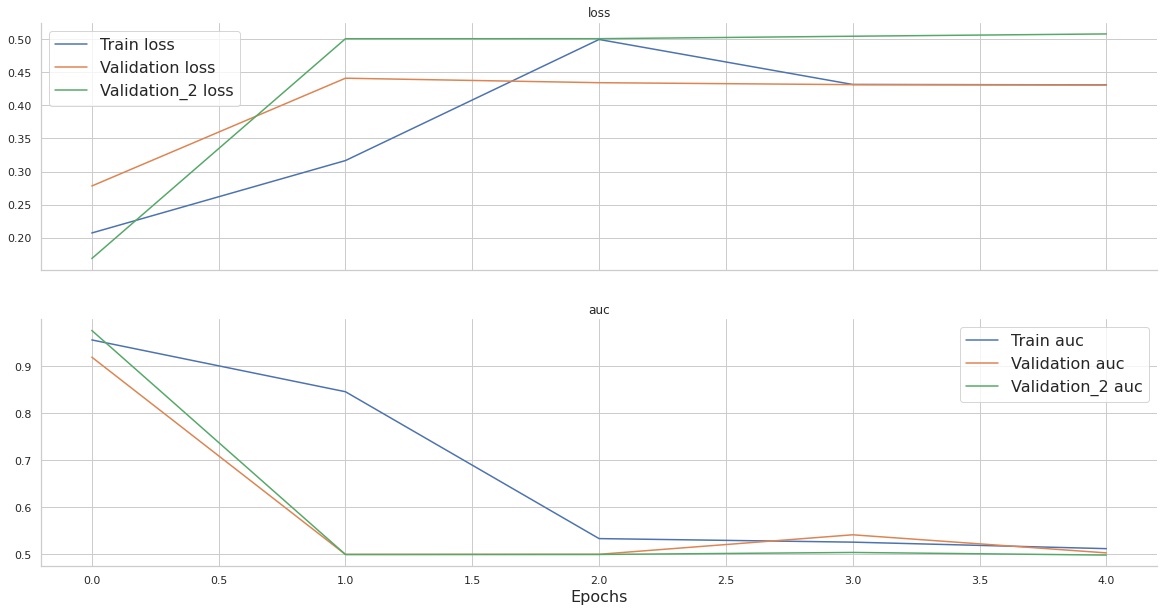

In [13]:
plot_metrics_2(history)

# Model evaluation

In [14]:
# display(evaluate_model_single_fold(k_fold, fold_n, label_col='toxic_int').style.applymap(color_map))

# Confusion matrix

In [15]:
# train_set = k_fold[k_fold[f'fold_{fold_n}'] == 'train']
# validation_set = k_fold[k_fold[f'fold_{fold_n}'] == 'validation'] 
# plot_confusion_matrix(train_set['toxic_int'], train_set[f'pred_{fold_n}'], 
#                       validation_set['toxic_int'], validation_set[f'pred_{fold_n}'])

# Model evaluation by language

In [16]:
display(evaluate_model_single_fold_lang(valid_df, fold_n).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_single_fold_lang(valid_df, fold_n, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.561200,0.561200
es,0.552700,0.552700
it,0.554298,0.554298
tr,0.553568,0.553568


,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.531689,0.531689
es,0.553675,0.553675
it,0.528913,0.528913
tr,0.491532,0.491532


# Visualize predictions

In [17]:
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,He should have been in Anchorage where selling Spice is a misdemeanor no matter how many people died from it or how ...,0.0000
1,"Completely untrue, he's an equal opportunity RACIST whom even hates whitey. We all know Trump represents no single r...",0.6000
2,Am I supposed to be scared? It's not like I can't just change my IP if I wanted to vandalize my own user page again....,1.0000
3,You realize this isn't a partisan issue right? BOTH dems and republicans do this shit constantly. Instead of blaming...,0.7413
4,Great article. Reads a bit like a Frederick Forsyth novel. Incredible how these spooks all work together. Niel Barna...,0.0000
5,"Exactly why the Con party are in opposition, and with stupid comments like this one, they will be there for a very l...",0.7571
6,Juneau PD appears to be clueless so far. Is this the norm??,0.0000
7,And Rachael Stevenson the racist.,0.8333
8,I think this a real reason for some people. But the main reason people drive in the left lane is that they are hopin...,0.0000
9,"You don't understand. Glenn was a great man (and if you hadn't mentioned Gagarin, I would have done it myself, just ...",0.0000


Multilingual validation set


,comment_text,toxic,pred_1,pred_ml_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.2020,0.1549
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.2026,0.1545
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.2035,0.1551
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.2015,0.1547
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.2016,0.1552
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.2016,0.1551
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.2025,0.1547
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.2018,0.1550
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.2022,0.1548
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.2026,0.1552


# Test set predictions

In [18]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [19]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.0000,63812.0000
mean,31905.5000,0.1551
std,18421.0820,0.0002
min,0.0000,0.1513
25%,15952.7500,0.1550
50%,31905.5000,0.1551
75%,47858.2500,0.1552
max,63811.0000,0.1598


,id,toxic
0,0,0.1554
1,1,0.1549
2,2,0.1550
3,3,0.1553
4,4,0.1548
5,5,0.1552
6,6,0.1550
7,7,0.1557
8,8,0.1552
9,9,0.1553
